# MOPO Parameterised

# Imports

In [17]:
import warnings
warnings.filterwarnings('ignore')
from offlinerlkit.nets import MLP
from offlinerlkit.modules import ActorProb, Critic, TanhDiagGaussian, EnsembleDynamicsModel
from offlinerlkit.dynamics import EnsembleDynamics
from offlinerlkit.utils.scaler import StandardScaler
from offlinerlkit.utils.termination_fns import get_termination_fn
from offlinerlkit.utils.load_dataset import qlearning_dataset
from offlinerlkit.buffer import ReplayBuffer
from offlinerlkit.utils.logger import Logger, make_log_dirs
from offlinerlkit.policy_trainer import MBPolicyTrainer
from offlinerlkit.policy import MOPOPolicy, COMBOPolicy
from typing import Literal
import torch
import numpy as np
import gym
import argparse
from tqdm import tqdm
import d4rl
from d4rl import qlearning_dataset
import time
import os
from torchviz import make_dot
import graphviz
import os
import sys
import random
import pandas as pd
# seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True

In [18]:
# Check if cuda is available
torch.cuda.is_available()

True

# Source function formatter

In [19]:
import inspect
import textwrap

def format_function_source(func):
    lines, _ = inspect.getsourcelines(func)
    source_code = ''.join(lines)
    
    # Dedent the source code
    dedented_code = textwrap.dedent(source_code)
    
    # Indent the dedented code to format it as a function
    indented_code = textwrap.indent(dedented_code, ' ' * 4)
    
    return indented_code

# Example: Define a function outside the notebook
def example_function():
    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        self._elapsed_steps += 1
        if self._elapsed_steps >= self._max_episode_steps:
            info["TimeLimit.truncated"] = not done
            done = True
        return observation, reward, done, info

# Format the function defined outside the notebook
formatted_code = format_function_source(example_function)
print(formatted_code)


    def example_function():
        def step(self, action):
            observation, reward, done, info = self.env.step(action)
            self._elapsed_steps += 1
            if self._elapsed_steps >= self._max_episode_steps:
                info["TimeLimit.truncated"] = not done
                done = True
            return observation, reward, done, info


# Retrieve gym environment

In [20]:
def gym_environment_creator(env_name:str) -> (gym.Env, int, int, int):
    """
    Create gym environment
    :param env_name: string of the environment name
    :return: 
    """
    # Create environment
    env = gym.make(env_name)
    dataset = env.get_dataset()
    obs_shape = env.observation_space.shape
    action_shape = env.action_space.shape
    max_action = env.action_space.high[0]
    
    # Create product
    obs_prod = np.prod(obs_shape)
    action_prod = np.prod(action_shape)
    
    return env, dataset, obs_prod, obs_shape, action_shape, action_prod, max_action

In [61]:
halfcheetah_d4rl, dataset, obs_prod, obs_shape, action_shape, action_prod, max_action = gym_environment_creator('halfcheetah-medium-v2')

load datafile: 100%|██████████| 21/21 [00:01<00:00, 13.41it/s]


In [22]:
print(format_function_source(halfcheetah_d4rl.step))

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        self._elapsed_steps += 1
        if self._elapsed_steps >= self._max_episode_steps:
            info["TimeLimit.truncated"] = not done
            done = True
        return observation, reward, done, info


# Arguments

In [23]:
from typing import Literal
import argparse

def args_generator(algo_name: Literal['mopo', 'combo'] = 'mopo', task_name: str ='halfcheetah-medium-v2'):
    template_args = {
        "mopo": {
            "algo_name": 'mopo',
            "hidden_dims": [256, 256],
        },
        "combo": {
            "algo_name": "combo",
            "hidden_dims": [256, 256, 256],
            "cql_weight": 0.5,
            "temperature": 1.0,
            "max_q_backup": False,
            "deterministic_backup": True,
            "with_lagrange": False,
            "lagrange_threshold": 10.0,
            "cql_alpha_lr": 3e-4,
            "num_repeat_actions": 10,
            "uniform_rollout": False,
            "rho_s": "mix",
        }
    }

    template_args[algo_name]["task"] = task_name
    template_args[algo_name]["seed"] = 1
    template_args[algo_name]["actor_lr"] = 1e-4
    template_args[algo_name]["critic_lr"] = 3e-4
    template_args[algo_name]["gamma"] = 0.99
    template_args[algo_name]["tau"] = 0.005
    template_args[algo_name]["alpha"] = 0.2
    template_args[algo_name]["alpha_lr"] = 1e-4
    template_args[algo_name]["auto_alpha"] = True
    template_args[algo_name]["target_entropy"] = None
    template_args[algo_name]["dynamics_lr"] = 1e-3
    template_args[algo_name]["dynamics_hidden_dims"] = [200, 200, 200, 200]
    template_args[algo_name]["dynamics_weight_decay"] = [2.5e-5, 5e-5, 7.5e-5, 7.5e-5, 1e-4]
    template_args[algo_name]["n_ensemble"] = 7
    template_args[algo_name]["n_elites"] = 5
    template_args[algo_name]["rollout_freq"] = 1000
    template_args[algo_name]["rollout_batch_size"] = 50000
    template_args[algo_name]["rollout_length"] = 5
    template_args[algo_name]["model_retain_epochs"] = 5
    template_args[algo_name]["load_dynamics_path"] = None
    template_args[algo_name]["epoch"] = 1000
    template_args[algo_name]["step_per_epoch"] = 1000
    template_args[algo_name]["eval_episodes"] = 10
    template_args[algo_name]["batch_size"] = 256
    template_args[algo_name]['penalty_coef'] = 0.5
    template_args[algo_name]["real_ratio"] = 0.05
    template_args[algo_name]["device"] = "cuda"
    
    # Halfcheetah specific settings
    template_args[algo_name]["obs_shape"] = obs_shape
    template_args[algo_name]["action_dim"] = action_prod
    template_args[algo_name]["max_action"] = max_action
    
    argument = template_args[algo_name]
    return argparse.Namespace(**argument)

mopo_args = args_generator(algo_name='mopo')
combo_args = args_generator(algo_name='combo')

In [24]:
mopo_args

Namespace(algo_name='mopo', hidden_dims=[256, 256], task='halfcheetah-medium-v2', seed=1, actor_lr=0.0001, critic_lr=0.0003, gamma=0.99, tau=0.005, alpha=0.2, alpha_lr=0.0001, auto_alpha=True, target_entropy=None, dynamics_lr=0.001, dynamics_hidden_dims=[200, 200, 200, 200], dynamics_weight_decay=[2.5e-05, 5e-05, 7.5e-05, 7.5e-05, 0.0001], n_ensemble=7, n_elites=5, rollout_freq=1000, rollout_batch_size=50000, rollout_length=5, model_retain_epochs=5, load_dynamics_path=None, epoch=1000, step_per_epoch=1000, eval_episodes=10, batch_size=256, penalty_coef=0.5, real_ratio=0.05, device='cuda', obs_shape=(17,), action_dim=6, max_action=1.0)

In [25]:
combo_args

Namespace(algo_name='combo', hidden_dims=[256, 256, 256], cql_weight=0.5, temperature=1.0, max_q_backup=False, deterministic_backup=True, with_lagrange=False, lagrange_threshold=10.0, cql_alpha_lr=0.0003, num_repeat_actions=10, uniform_rollout=False, rho_s='mix', task='halfcheetah-medium-v2', seed=1, actor_lr=0.0001, critic_lr=0.0003, gamma=0.99, tau=0.005, alpha=0.2, alpha_lr=0.0001, auto_alpha=True, target_entropy=None, dynamics_lr=0.001, dynamics_hidden_dims=[200, 200, 200, 200], dynamics_weight_decay=[2.5e-05, 5e-05, 7.5e-05, 7.5e-05, 0.0001], n_ensemble=7, n_elites=5, rollout_freq=1000, rollout_batch_size=50000, rollout_length=5, model_retain_epochs=5, load_dynamics_path=None, epoch=1000, step_per_epoch=1000, eval_episodes=10, batch_size=256, penalty_coef=0.5, real_ratio=0.05, device='cuda', obs_shape=(17,), action_dim=6, max_action=1.0)

# Build MOPO

In [26]:
def mopo(args = mopo_args, env: gym.Env = halfcheetah_d4rl, dataset: dict = dataset, saved_policy: str = None,
         saved_dynamics: str = None):
    """
    Build MOPO
    :param args: dictionary of arguments 
    :param env: gym environment
    :param dataset: dataset from d4rl
    :param saved_policy: path to saved policy
    :param saved_dynamics: path to saved dynamics model
    :return: mopo policy and policytrainer from offlinerlkit
    """
    # Set seed
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    np.random.seed(args.seed)
    random.seed(args.seed)
    
    # Create backbones
    actor_backbone = MLP(input_dim=np.prod(args.obs_shape), hidden_dims=args.hidden_dims)
    critic1_backbone = MLP(input_dim=np.prod(args.obs_shape) + args.action_dim, hidden_dims=[256,256])
    critic2_backbone = MLP(input_dim=np.prod(args.obs_shape) + args.action_dim, hidden_dims=args.hidden_dims)
    dist = TanhDiagGaussian(
        latent_dim=getattr(actor_backbone, "output_dim"),
        output_dim=args.action_dim,
        unbounded=True,
        conditioned_sigma=True
    )
    
    # Create actor and critic networks
    actor = ActorProb(actor_backbone, dist, args.device)
    critic1 = Critic(critic1_backbone, args.device)
    critic2 = Critic(critic2_backbone, args.device)
    actor_optim = torch.optim.Adam(actor.parameters(), lr=args.actor_lr)
    critic1_optim = torch.optim.Adam(critic1.parameters(), lr=args.critic_lr)
    critic2_optim = torch.optim.Adam(critic2.parameters(), lr=args.critic_lr)
    
    # Create lr scheduler
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(actor_optim, T_max=args.epoch)

    # Create alpha
    if args.auto_alpha:
        target_entropy = args.target_entropy if args.target_entropy \
            else -np.prod(env.action_space.shape)
    
        args.target_entropy = target_entropy
    
        log_alpha = torch.zeros(1, requires_grad=True, device=args.device)
        alpha_optim = torch.optim.Adam([log_alpha], lr=args.alpha_lr)
        alpha = (target_entropy, log_alpha, alpha_optim)
    else:
        alpha = args.alpha
        
    # Create dynamics model ensemble
    dynamics_model = EnsembleDynamicsModel(
        obs_dim=np.prod(args.obs_shape),
        action_dim=args.action_dim,
        hidden_dims=args.dynamics_hidden_dims,
        num_ensemble=args.n_ensemble,
        num_elites=args.n_elites,
        weight_decays=args.dynamics_weight_decay,
        device=args.device
    )
    dynamics_optim = torch.optim.Adam(
        dynamics_model.parameters(),
        lr=args.dynamics_lr
    )
    scaler = StandardScaler()
    termination_fn = get_termination_fn(task=args.task)
    dynamics = EnsembleDynamics(
        dynamics_model,
        dynamics_optim,
        scaler,
        termination_fn,
        penalty_coef=args.penalty_coef,
    )
    
    # Create policy
    policy = MOPOPolicy(
        dynamics,
        actor,
        critic1,
        critic2,
        actor_optim,
        critic1_optim,
        critic2_optim,
        tau=args.tau,
        gamma=args.gamma,
        alpha=alpha
    )

    # Create replay buffer
    real_buffer = ReplayBuffer(
        buffer_size=len(dataset["observations"]),
        obs_shape=args.obs_shape,
        obs_dtype=np.float32,
        action_dim=args.action_dim,
        action_dtype=np.float32,
        device=args.device
    )
    real_buffer.load_dataset(dataset)
    fake_buffer = ReplayBuffer(
        buffer_size=args.rollout_batch_size*args.rollout_length*args.model_retain_epochs,
        obs_shape=args.obs_shape,
        obs_dtype=np.float32,
        action_dim=args.action_dim,
        action_dtype=np.float32,
        device=args.device
    )
    
    # Create logger
    log_dirs = make_log_dirs(args.task, args.algo_name, args.seed, vars(args), record_params=["penalty_coef", "rollout_length"])
    # key: output file name, value: output handler type
    output_config = {
        "consoleout_backup": "stdout",
        "policy_training_progress": "csv",
        "dynamics_training_progress": "csv",
        "tb": "tensorboard"
    }
    logger = Logger(log_dirs, output_config)
    logger.log_hyperparameters(vars(args))

    
    # Load policy
    if saved_policy:
        policy.load_state_dict(torch.load(saved_policy))
        
    # Create policy trainer
    policy_trainer = MBPolicyTrainer(
        policy=policy,
        eval_env=env,
        real_buffer=real_buffer,
        fake_buffer=fake_buffer,
        logger=logger,
        rollout_setting=(args.rollout_freq, args.rollout_batch_size, args.rollout_length),
        epoch=args.epoch,
        step_per_epoch=args.step_per_epoch,
        batch_size=args.batch_size,
        real_ratio=args.real_ratio,
        eval_episodes=args.eval_episodes,
        lr_scheduler=lr_scheduler,
    )
    
    return policy, policy_trainer
        
    
    

In [27]:
# Initialise a HALFCHEETAH policy and policy trainer
mopo_policy, policy_trainer = mopo(saved_policy='/home/pradyutnair/Documents/Thesis/CARL/log/halfcheetah-medium-v2/mopo/seed_3_timestamp_23-0103-130104/checkpoint/policy.pth', saved_dynamics='/home/pradyutnair/Documents/Thesis/CARL/log/halfcheetah-medium-v2/mopo/seed_2_timestamp_23-0103-130105/model/dynamics.pth')

# Build COMBO

In [28]:
def combo(args = combo_args, env: gym.Env = halfcheetah_d4rl, dataset: dict = dataset, saved_policy: str = None,
         saved_dynamics: str = None):
    """
    Build MOPO
    :param args: dictionary of arguments 
    :param env: gym environment
    :param dataset: dataset from d4rl
    :param saved_policy: path to saved policy
    :param saved_dynamics: path to saved dynamics model
    :return: mopo policy and policytrainer from offlinerlkit
    """
    # Set seed
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True
    env.seed(args.seed)
    
    # Create backbones
    actor_backbone = MLP(input_dim=np.prod(args.obs_shape), hidden_dims=args.hidden_dims)
    critic1_backbone = MLP(input_dim=np.prod(args.obs_shape) + args.action_dim, hidden_dims=args.hidden_dims)
    critic2_backbone = MLP(input_dim=np.prod(args.obs_shape) + args.action_dim, hidden_dims=args.hidden_dims)
    dist = TanhDiagGaussian(
        latent_dim=getattr(actor_backbone, "output_dim"),
        output_dim=args.action_dim,
        unbounded=True,
        conditioned_sigma=True
    )
    
    # Create actor and critic networks
    actor = ActorProb(actor_backbone, dist, args.device)
    critic1 = Critic(critic1_backbone, args.device)
    critic2 = Critic(critic2_backbone, args.device)
    actor_optim = torch.optim.Adam(actor.parameters(), lr=args.actor_lr)
    critic1_optim = torch.optim.Adam(critic1.parameters(), lr=args.critic_lr)
    critic2_optim = torch.optim.Adam(critic2.parameters(), lr=args.critic_lr)
    
    # Create lr scheduler
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(actor_optim, T_max=args.epoch)

    # Create alpha
    if args.auto_alpha:
        target_entropy = args.target_entropy if args.target_entropy \
            else -np.prod(env.action_space.shape)
    
        args.target_entropy = target_entropy
    
        log_alpha = torch.zeros(1, requires_grad=True, device=args.device)
        alpha_optim = torch.optim.Adam([log_alpha], lr=args.alpha_lr)
        alpha = (target_entropy, log_alpha, alpha_optim)
    else:
        alpha = args.alpha
        
    # Create dynamics model ensemble
    dynamics_model = EnsembleDynamicsModel(
        obs_dim=np.prod(args.obs_shape),
        action_dim=args.action_dim,
        hidden_dims=args.dynamics_hidden_dims,
        num_ensemble=args.n_ensemble,
        num_elites=args.n_elites,
        weight_decays=args.dynamics_weight_decay,
        device=args.device
    )
    dynamics_optim = torch.optim.Adam(
        dynamics_model.parameters(),
        lr=args.dynamics_lr
    )
    scaler = StandardScaler()
    termination_fn = get_termination_fn(task=args.task)
    dynamics = EnsembleDynamics(
        dynamics_model,
        dynamics_optim,
        scaler,
        termination_fn,
        penalty_coef=args.penalty_coef,
    )
    
    if saved_dynamics:
        dynamics.load(saved_dynamics)
    
    # Create policy
    policy = COMBOPolicy(
        dynamics,
        actor,
        critic1,
        critic2,
        actor_optim,
        critic1_optim,
        critic2_optim,
        action_space=env.action_space,
        tau=args.tau,
        gamma=args.gamma,
        alpha=alpha,
        cql_weight=args.cql_weight,
        temperature=args.temperature,
        max_q_backup=args.max_q_backup,
        deterministic_backup=args.deterministic_backup,
        with_lagrange=args.with_lagrange,
        lagrange_threshold=args.lagrange_threshold,
        cql_alpha_lr=args.cql_alpha_lr,
        num_repeart_actions=args.num_repeat_actions,
        uniform_rollout=args.uniform_rollout,
        rho_s=args.rho_s
    )

    # Create replay buffer
    real_buffer = ReplayBuffer(
        buffer_size=len(dataset["observations"]),
        obs_shape=args.obs_shape,
        obs_dtype=np.float32,
        action_dim=args.action_dim,
        action_dtype=np.float32,
        device=args.device
    )
    real_buffer.load_dataset(dataset)
    fake_buffer = ReplayBuffer(
        buffer_size=args.rollout_batch_size*args.rollout_length*args.model_retain_epochs,
        obs_shape=args.obs_shape,
        obs_dtype=np.float32,
        action_dim=args.action_dim,
        action_dtype=np.float32,
        device=args.device
    )
    
    # Create logger
    log_dirs = make_log_dirs(args.task, args.algo_name, args.seed, vars(args), record_params=["penalty_coef", "rollout_length"])
    # key: output file name, value: output handler type
    output_config = {
        "consoleout_backup": "stdout",
        "policy_training_progress": "csv",
        "dynamics_training_progress": "csv",
        "tb": "tensorboard"
    }
    logger = Logger(log_dirs, output_config)
    logger.log_hyperparameters(vars(args))

    
    # Load policy
    if saved_policy:
        policy.load_state_dict(torch.load(saved_policy, map_location=torch.device('cpu')))
        
    # Create policy trainer
    policy_trainer = MBPolicyTrainer(
        policy=policy,
        eval_env=env,
        real_buffer=real_buffer,
        fake_buffer=fake_buffer,
        logger=logger,
        rollout_setting=(args.rollout_freq, args.rollout_batch_size, args.rollout_length),
        epoch=args.epoch,
        step_per_epoch=args.step_per_epoch,
        batch_size=args.batch_size,
        real_ratio=args.real_ratio,
        eval_episodes=args.eval_episodes,
        lr_scheduler=lr_scheduler,
    )
    
    return policy, policy_trainer
    

In [29]:
combo_args.cql_weight

0.5

In [30]:
# Load pre-trained COMBO policy
combo_policy, combo_policy_trainer = combo(saved_policy='/home/pradyutnair/Documents/Thesis/CARL/log/halfcheetah-medium-v2/combo/seed_3_timestamp_23-0506-040857/checkpoint/policy.pth', saved_dynamics='/home/pradyutnair/Documents/Thesis/CARL/log/halfcheetah-medium-v2/combo/seed_3_timestamp_23-0506-040857/model/')

# Environments

### CARL Cheetah

In [31]:
import matplotlib.pyplot as plt
from carl.context.context_space import NormalFloatContextFeature
from carl.context.sampler import ContextSampler
from carl.envs import CARLBraxAnt, CARLBraxHalfcheetah

/home/pradyutnair/Documents/Thesis/OfflineRL-Kit/CARL/carl/envs/__init__.py:28: UserWarning: Module Box2D not found. If you want to use these environments, please follow the installation guide.
  warnings.warn(
/home/pradyutnair/Documents/Thesis/OfflineRL-Kit/CARL/carl/envs/__init__.py:28: UserWarning: Module py4j not found. If you want to use these environments, please follow the installation guide.
  warnings.warn(


In [32]:
def jax_to_torch(jax_array):
    return torch.from_numpy(np.array(jax_array)).float().to("cuda")

In [33]:
scaling_factor = 2.75
context_dict = {'gravity': -9.8,
  'friction': 1.0,
  'elasticity': 0.0,
  'ang_damping': -0.05,
  'viscosity': 0.0,
  'mass_torso': 10.0,
  'mass_bthigh': 1.5435146,
  'mass_bshin': 1.5874476,
  'mass_bfoot': 1.0953975,
  'mass_fthigh': 1.4380753,
  'mass_fshin': 1.2008368,
  'mass_ffoot': 0.8845188}
# Multiply all values in the dictionary by scaling factor
context_dict = {k: v * scaling_factor for k, v in context_dict.items() if k != 'gravity'}
context_dict['gravity'] = -9.8
context_dict

{'friction': 2.75,
 'elasticity': 0.0,
 'ang_damping': -0.1375,
 'viscosity': 0.0,
 'mass_torso': 27.5,
 'mass_bthigh': 4.244665149999999,
 'mass_bshin': 4.3654809,
 'mass_bfoot': 3.012343125,
 'mass_fthigh': 3.954707075,
 'mass_fshin': 3.3023012,
 'mass_ffoot': 2.4324267,
 'gravity': -9.8}

In [34]:
modified_cheetah = CARLBraxHalfcheetah(context=context_dict)
# check that the obs are of shape (17,
modified_cheetah.reset()[0]['obs'].shape

(17,)

In [35]:
print(format_function_source(modified_cheetah.step))

    def step(
        self, action: Any
    ) -> tuple[Any, SupportsFloat, bool, bool, dict[str, Any]]:
        """Step the environment.

        The context is added to the observation returned by the
        wrapped environment.

        Parameters
        ----------
        action : Any
            Action

        Returns
        -------
        tuple[Any, SupportsFloat, bool, bool, dict[str, Any]]
            Observation, rewar, terminated, truncated, info.
        """
        state, reward, terminated, truncated, info = super().step(action)
        state = self._add_context_to_state(state)
        info["context_id"] = self.context_id
        return state, reward, terminated, truncated, info


### Crippled Cheetah

In [36]:
import numpy as np
import os
import torch
from gym import utils
from gym.envs.mujoco import mujoco_env

class CrippleHalfCheetahEnv(mujoco_env.MujocoEnv, utils.EzPickle):
    def __init__(self, cripple_set=None, extreme_set=None):
        """
        If extreme set=[0], neutral
        If extreme set=[1], extreme
        """
        self.crippled_joint = None
        if extreme_set is None:
            extreme_set = [0]
        if cripple_set is None:
            cripple_set = [0, 1, 2, 3]
        self.prev_qpos = None

        self.cripple_mask = None

        mujoco_env.MujocoEnv.__init__(self, os.path.join(os.path.abspath(''), 'assets', 'half_cheetah.xml'), 5)

        self.cripple_mask = np.ones(self.action_space.shape)
        self.cripple_set = cripple_set
        self.extreme_set = extreme_set

        self._init_geom_rgba = self.model.geom_rgba.copy()
        self._init_geom_contype = self.model.geom_contype.copy()
        self._init_geom_size = self.model.geom_size.copy()
        self._init_geom_pos = self.model.geom_pos.copy()

        utils.EzPickle.__init__(self, cripple_set, extreme_set)

    def _set_observation_space(self, observation):
        super(CrippleHalfCheetahEnv, self)._set_observation_space(observation)
        proc_observation = self.obs_preproc(observation[None])
        self.proc_observation_space_dims = proc_observation.shape[-1]

    def step(self, action):
        self.prev_qpos = np.copy(self.sim.data.qpos.flat)
        if self.cripple_mask is None:
            action = action
        else:
            action = self.cripple_mask * action
        self.do_simulation(action, self.frame_skip)
        ob = self._get_obs()

        reward_ctrl = -0.1  * np.square(action).sum()
        reward_run = ob[0]
        reward = reward_run + reward_ctrl

        done = False
        return ob, reward, done, {}

    def _get_obs(self):
        return np.concatenate([
            (self.sim.data.qpos.flat[:1] - self.prev_qpos[:1]) / self.dt,
            self.sim.data.qpos.flat[1:],
            self.sim.data.qvel.flat,
        ])

    @staticmethod
    def obs_preproc(obs):
        if isinstance(obs, np.ndarray):
            return np.concatenate([obs[..., 1:2], np.sin(obs[..., 2:3]), np.cos(obs[..., 2:3]), obs[..., 3:]], axis=-1)
        else:
            return torch.cat([obs[..., 1:2], torch.sin(obs[..., 2:3]), torch.cos(obs[..., 2:3]), obs[..., 3:]], dim=-1)

    @staticmethod
    def obs_postproc(obs, pred):
        if isinstance(obs, np.ndarray):
            return np.concatenate([pred[..., :1], obs[..., 1:] + pred[..., 1:]], axis=-1)
        else:
            return torch.cat([pred[..., :1], obs[..., 1:] + pred[..., 1:]], dim=-1)
        
    @staticmethod
    def targ_proc(self, obs, next_obs):
        return np.concatenate([next_obs[..., :1], next_obs[..., 1:] - obs[..., 1:]], axis=-1)

    def reset_model(self):
        qpos = self.init_qpos + self.np_random.normal(loc=0, scale=0.001, size=self.model.nq)
        qvel = self.init_qvel + self.np_random.normal(loc=0, scale=0.001, size=self.model.nv)
        self.set_state(qpos, qvel)
        self.prev_qpos = np.copy(self.sim.data.qpos.flat)

        self.change_env()
        return self._get_obs()

    @staticmethod
    def reward(obs, action, next_obs):
        ctrl_cost = 1e-1 * np.sum(np.square(action), axis=-1)
        forward_reward = obs[..., 0]
        reward = forward_reward - ctrl_cost
        return reward
    
    @staticmethod
    def tf_reward_fn():
        def _thunk(obs, act, next_obs):
            ctrl_cost = 1e-1  * torch.sum(torch.square(act), dim=-1)
            forward_reward = obs[..., 0]
            reward = forward_reward - ctrl_cost
            return reward
        return _thunk
    
    def change_env(self):
        action_dim = self.action_space.shape
        if self.extreme_set == [0]:
            self.crippled_joint = np.array([self.np_random.choice(self.cripple_set)])
        elif self.extreme_set == [1]:
            self.crippled_joint = self.np_random.choice(self.cripple_set, 2, replace=False)
        else:
            raise ValueError(self.extreme_set)
        self.cripple_mask = np.ones(action_dim)
        self.cripple_mask[self.crippled_joint] = 0

        geom_rgba = self._init_geom_rgba.copy()
        for joint in self.crippled_joint:
            geom_idx = self.model.geom_names.index(self.model.joint_names[joint+3])
            geom_rgba[geom_idx, :3] = np.array([1, 0, 0])
        self.model.geom_rgba[:] = geom_rgba.copy()

    def viewer_setup(self):
        self.viewer.cam.distance = self.model.stat.extent * 0.25
        self.viewer.cam.elevation = -55
    
    def get_sim_parameters(self):
        return np.array([self.cripple_mask])
    
    @staticmethod
    def num_modifiable_parameters():
        return 1

    def log_diagnostics(self, paths, prefix):
        return


# Evaluation Function

In [37]:
def evaluate_policy(agent_policy, eval_episodes=10,
                    render=False, env=halfcheetah_d4rl, 
                    remove_first_obs=False, convert_jax_to_torch=False,
                    seed:int=42) -> pd.DataFrame:
    """
    Evaluate the policy given the agent policy, environment, and other parameters
    :param agent_policy: policy of the agent
    :param eval_episodes: number of episodes to evaluate
    :param render: whether to render the environment    
    :param env:  to evaluate the policy
    :param remove_first_obs: remove the first obs if it is a CARL environment (redundant obs)
    :param convert_jax_to_torch: boolean to convert jax array to torch array
    :param seed: seed for reproducibility
    :return: dataframe of the evaluation results
    """
    # Set seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Reset the observations
    obs = env.reset(seed=seed)
    
    # Check if it needs to be converted to torch
    if convert_jax_to_torch:
        obs = env.reset()[0]['obs'] 
        obs = jax_to_torch(obs)
    # Check if first observation needs to be removed
    obs = obs[1:] if remove_first_obs else obs 
    
    # Initiate variables
    eval_ep_info_buffer = []
    num_episodes = 0
    episode_reward = 0
    episode_length = 0
    
    # Iterate through the episodes
    with tqdm(total=eval_episodes, dynamic_ncols=True) as pbar:
        # Iterate through the episodes until episode length 1000 is reached
        while num_episodes < eval_episodes:
            # For each episode, reset the reward buffer
            reward_buffer = []
            # Select action
            action = agent_policy.select_action(obs.reshape(1, -1), deterministic=True)
            # Take a step
            try:
                next_obs, reward, done, _ = env.step(action.flatten())
            except ValueError as e:
                next_obs, reward, done, truncated, _ = env.step(action.flatten())
            
            # Append reward to reward buffer
            reward_buffer.append(reward)
            # Update episode reward and episode length
            episode_reward += reward
            episode_length += 1
            # Check if the new obs needs to be converted to torch
            if convert_jax_to_torch:
                next_obs = next_obs['obs'] 
                next_obs = jax_to_torch(next_obs)
            # Check if first observation needs to be removed
            next_obs = next_obs[1:] if remove_first_obs else next_obs
            obs = next_obs
            
            # End the episode if done or episode length is 1000
            if done or episode_length == 1000:
                eval_ep_info_buffer.append(
                    {"timestep": num_episodes,
                     "episode_reward": episode_reward,
                     "normalized_reward": halfcheetah_d4rl.get_normalized_score(episode_reward) * 100,
                     "episode_length": episode_length,
                     "mean_reward": round((episode_reward / episode_length), 2),
                     "std_reward": np.round(np.std(reward_buffer), 5),
                     })
                # Increment the number of episodes
                num_episodes += 1
                # Update the progress bar
                pbar.update(1)  
                # Reset the episode (rewrite the code)
                obs = env.reset()
                # Set the seed again
                torch.manual_seed(seed)
                torch.cuda.manual_seed_all(seed)
                np.random.seed(seed)
                random.seed(seed)
                # Check if it needs to be converted to torch
                if convert_jax_to_torch:
                    obs = env.reset()[0]['obs'] 
                    obs = jax_to_torch(obs)
                # Check if first observation needs to be removed
                obs = obs[1:] if remove_first_obs else obs 
                # Reset the episode reward and episode length
                episode_reward, episode_length = 0, 0
            
            if render:
                env.render()
    # Convert the result buffer to a dataframe
    result_df = pd.DataFrame(eval_ep_info_buffer)
    return result_df

# Test

## Plotting function

In [38]:
def plotter(result_df, title, save_path=None):
    plt.figure(figsize=(10, 5))
    plt.plot(result_df['timestep'], result_df['normalized_reward'])
    plt.xlabel('Timestep')
    plt.ylabel('Normalized reward')
    plt.title(title)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

100%|██████████| 10/10 [00:12<00:00,  1.22s/it]


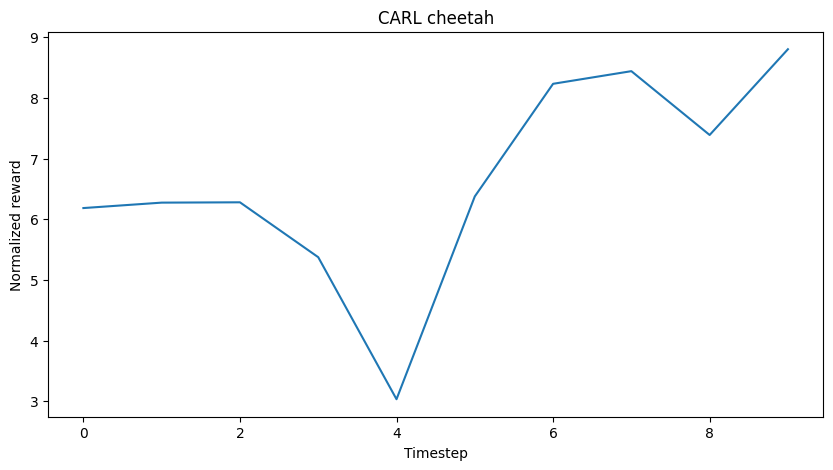

In [39]:
mod_result = evaluate_policy(mopo_policy, eval_episodes=10, render=False, env=modified_cheetah, remove_first_obs=False, convert_jax_to_torch=True)
plotter(mod_result, 'CARL cheetah', save_path='/home/pradyutnair/Documents/Thesis/CARL/log/halfcheetah-medium-v2/mopo/modified_cheetah.png')

100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


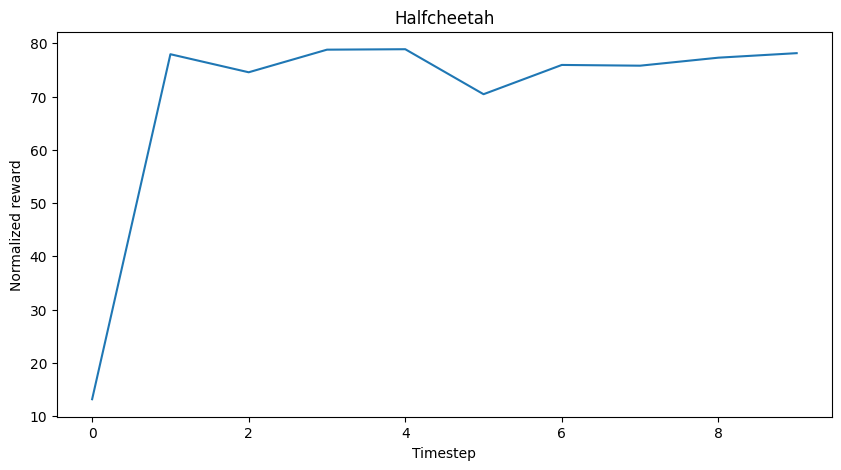

In [40]:
result = evaluate_policy(mopo_policy, eval_episodes=10,
                          render=False, env=halfcheetah_d4rl, remove_first_obs=False)
plotter(result, 'Halfcheetah', save_path='/home/pradyutnair/Documents/Thesis/CARL/log/halfcheetah-medium-v2/mopo/halfcheetah.png')

In [41]:
# result = policy_trainer._evaluate()

In [42]:
# result.keys()

In [43]:
# plt.plot(np.arange(len(result['eval/episode_reward'])), result['eval/episode_reward'])

### Cripple cheetah test

In [44]:
crippled_cheetah = CrippleHalfCheetahEnv()
# obs = crippled_cheetah.reset()[1:]
# # n_test = 0
# # total_reward_list = []
# mopo_policy.select_action(obs)
crip_result = evaluate_policy(mopo_policy, eval_episodes=10, render=False, env=crippled_cheetah, remove_first_obs=True)

100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


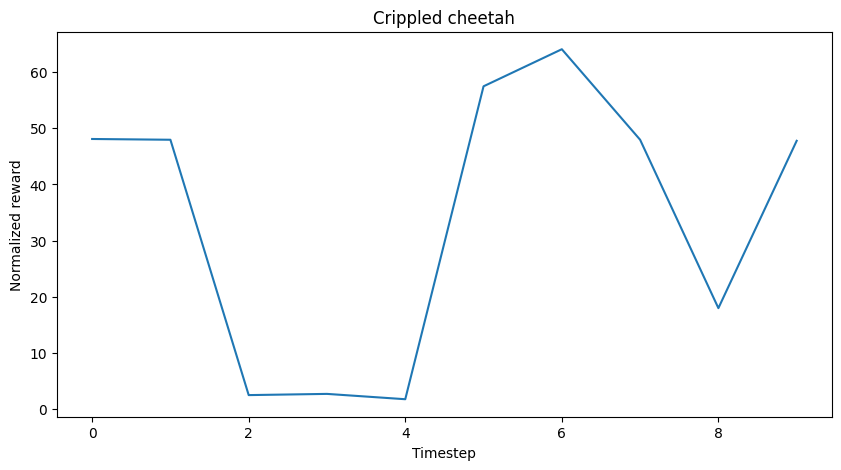

In [45]:
plotter(crip_result, 'Crippled cheetah', save_path='/home/pradyutnair/Documents/Thesis/CARL/log/halfcheetah-medium-v2/mopo/crippled_cheetah.png')

# Benchmark

```
for s in seed:
    for d in dataset:
        for p in policy:
            <evaluate policy p on dataset d (set with seed s)>
             <save results>
```python

In [59]:
import os
from itertools import product
from tqdm import tqdm
import datetime

def benchmark(datasets, policies, seeds, save_dir, eval_episodes: int = 10):
    timestamp = datetime.datetime.now().strftime("%d_%m%_y_%H%M%S")

    for dataset_key, dataset_value in datasets.items():
        for policy_key, policy_value in policies.items():
            for seed in seeds:
                print(f"Running policy {policy_key.upper()} on dataset {dataset_key} with seed {seed}")
                # Check if dataset is a CARL environment
                if type(dataset_value.reset()) != np.ndarray:
                    convert_jax_to_torch = True
                else:
                    convert_jax_to_torch = False
                if dataset_key == "crippled_cheetah":
                    remove_first_obs = True
                else:
                    remove_first_obs = False
                # Evaluate policy on dataset with seed
                result_df = evaluate_policy(agent_policy=policy_value, eval_episodes=eval_episodes, env=dataset_value,
                                            convert_jax_to_torch=convert_jax_to_torch,
                                            remove_first_obs=remove_first_obs, seed=seed)

                # Create directory for saving results where the root directory is the timestamp
                timestamp_dir = os.path.join(save_dir, timestamp)
                policy_dir = os.path.join(timestamp_dir, policy_key)
                seed_dir = os.path.join(policy_dir, f"seed_{seed}")
                dataset_dir = os.path.join(seed_dir, dataset_key)
                os.makedirs(dataset_dir, exist_ok=True)
                print(f"Saving results to {dataset_dir}")
                # Save results as CSV file
                result_file = os.path.join(dataset_dir, "results.csv")
                result_df.to_csv(result_file, index=False)
    print("Benchmarking completed successfully!")


In [60]:
datasets = {
    "halfcheetah-medium-v2": halfcheetah_d4rl,
    "modified_cheetah": modified_cheetah,
    "crippled_cheetah": crippled_cheetah
}
policies = {
    "mopo": mopo_policy,
    "combo": combo_policy
}
seeds = [1, 2, 3]
save_dir = "/home/pradyutnair/Documents/Thesis/CARL/eval_results"
benchmark(datasets, policies, seeds, save_dir, eval_episodes=3000)

Running policy MOPO on dataset halfcheetah-medium-v2 with seed 1


100%|██████████| 1/1 [00:00<00:00,  1.73it/s]


Saving results to /home/pradyutnair/Documents/Thesis/CARL/eval_results/12_1123_165220/mopo/seed_1/halfcheetah-medium-v2
Running policy MOPO on dataset halfcheetah-medium-v2 with seed 2


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


Saving results to /home/pradyutnair/Documents/Thesis/CARL/eval_results/12_1123_165220/mopo/seed_2/halfcheetah-medium-v2
Running policy MOPO on dataset halfcheetah-medium-v2 with seed 3


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Saving results to /home/pradyutnair/Documents/Thesis/CARL/eval_results/12_1123_165220/mopo/seed_3/halfcheetah-medium-v2
Running policy COMBO on dataset halfcheetah-medium-v2 with seed 1


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


Saving results to /home/pradyutnair/Documents/Thesis/CARL/eval_results/12_1123_165220/combo/seed_1/halfcheetah-medium-v2
Running policy COMBO on dataset halfcheetah-medium-v2 with seed 2


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


Saving results to /home/pradyutnair/Documents/Thesis/CARL/eval_results/12_1123_165220/combo/seed_2/halfcheetah-medium-v2
Running policy COMBO on dataset halfcheetah-medium-v2 with seed 3


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


Saving results to /home/pradyutnair/Documents/Thesis/CARL/eval_results/12_1123_165220/combo/seed_3/halfcheetah-medium-v2
Running policy MOPO on dataset modified_cheetah with seed 1


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


Saving results to /home/pradyutnair/Documents/Thesis/CARL/eval_results/12_1123_165220/mopo/seed_1/modified_cheetah
Running policy MOPO on dataset modified_cheetah with seed 2


100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


Saving results to /home/pradyutnair/Documents/Thesis/CARL/eval_results/12_1123_165220/mopo/seed_2/modified_cheetah
Running policy MOPO on dataset modified_cheetah with seed 3


100%|██████████| 1/1 [00:00<00:00,  1.49it/s]


Saving results to /home/pradyutnair/Documents/Thesis/CARL/eval_results/12_1123_165220/mopo/seed_3/modified_cheetah
Running policy COMBO on dataset modified_cheetah with seed 1


100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


Saving results to /home/pradyutnair/Documents/Thesis/CARL/eval_results/12_1123_165220/combo/seed_1/modified_cheetah
Running policy COMBO on dataset modified_cheetah with seed 2


100%|██████████| 1/1 [00:00<00:00,  1.28it/s]


Saving results to /home/pradyutnair/Documents/Thesis/CARL/eval_results/12_1123_165220/combo/seed_2/modified_cheetah
Running policy COMBO on dataset modified_cheetah with seed 3


100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


Saving results to /home/pradyutnair/Documents/Thesis/CARL/eval_results/12_1123_165220/combo/seed_3/modified_cheetah
Running policy MOPO on dataset crippled_cheetah with seed 1


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]


Saving results to /home/pradyutnair/Documents/Thesis/CARL/eval_results/12_1123_165220/mopo/seed_1/crippled_cheetah
Running policy MOPO on dataset crippled_cheetah with seed 2


100%|██████████| 1/1 [00:00<00:00,  1.98it/s]


Saving results to /home/pradyutnair/Documents/Thesis/CARL/eval_results/12_1123_165220/mopo/seed_2/crippled_cheetah
Running policy MOPO on dataset crippled_cheetah with seed 3


100%|██████████| 1/1 [00:00<00:00,  2.12it/s]


Saving results to /home/pradyutnair/Documents/Thesis/CARL/eval_results/12_1123_165220/mopo/seed_3/crippled_cheetah
Running policy COMBO on dataset crippled_cheetah with seed 1


  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [48]:
def average_return(datasets, policies, seeds, save_dir):
    policy_avg_rewards = {}  # Dictionary to store average rewards for each policy
    print("Calculating average rewards for each policy")
    
    for policy_key, policy_value in policies.items():
        policy_rewards = []  # List to store rewards for each policy
        
        for seed in seeds:
            for dataset_key in datasets:
                dataset_dir = os.path.join(save_dir, policy_key, f"seed_{seed}", dataset_key)
                result_file = os.path.join(dataset_dir, "results.csv")
                
                curr_cwd = os.getcwd()
                curr_path = os.path.join(curr_cwd, result_file)
                
                if os.path.exists(curr_path):
                    result_df = pd.read_csv(curr_path)
                    avg_reward = result_df['normalized_reward'].mean()
                    policy_rewards.append(avg_reward)
        
        policy_avg_rewards[policy_key] = sum(policy_rewards) / len(policy_rewards)
    
    return policy_avg_rewards

# Specify the directory where the results are saved
save_dir = "eval_results"

# Run the benchmarking and get the average rewards for each policy
policy_avg_rewards = average_return(datasets, policies, seeds, save_dir)
policy_avg_rewards

Calculating average rewards for each policy


{'mopo': 35.18498496188009, 'combo': 38.13468417040757}

# 1D MDP

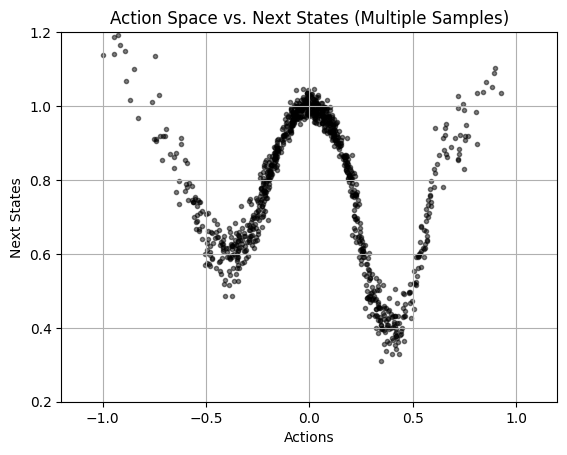

In [49]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)
# Number of samples
num_samples = 1000

# Initialize arrays to store next states for each action and actions
next_states = []
actions = []

# Define the transition model based on the original function
def transition_model(action):
    # Parameters based on Table V
    if -1 <= action < -0.6:
        mu = -action + 0.2
        sigma = 0.06
    elif -0.6 <= action < -0.2:
        mu = 5 * (action + 0.4) ** 2 + 0.6
        sigma = 0.04
    elif -0.2 <= action < 0.2:
        mu = -5 * (action ** 2) + 1
        sigma = 0.02
    elif 0.2 <= action < 0.6:
        mu = 10 * (action - 0.4) ** 2 + 0.4
        sigma = 0.04
    elif 0.6 <= action <= 1:
        mu = action + 0.2
        sigma = 0.06
    else:
        raise ValueError("Action out of range")
    # Sample the next state from the Gaussian distribution
    next_state = np.random.normal(mu, sigma)
    return next_state

# Sample next states for all possible actions
for _ in range(num_samples):
    # Sample an action using N(0, 0.35)
    action = np.random.normal(loc=0, scale=0.35)
    action = min(1, max(-1, action))  # Clip the action to [-1, 1]
    actions.append(action)

    # Generate the next state for the sampled action
    next_state = transition_model(action)
    next_states.append(next_state)

# Create the scatter plot
plt.scatter(actions, next_states, c='black', marker='o', alpha=0.5, s=9)  # Use alpha to make dots semi-transparent

plt.xlabel('Actions')
plt.ylabel('Next States')
plt.title('Action Space vs. Next States (Multiple Samples)')
plt.grid()
plt.xlim(-1.2, 1.2)
plt.ylim(0.2, 1.2)  # Adjusted to include all possible values
plt.show()